# Campaign-to-Pipeline Analytics (Synthetic Dataset)

This notebook analyzes a synthetic B2B campaign-to-pipeline dataset to answer:

1. Which campaigns create the highest win rate?
2. Which campaigns create bigger deals?
3. Which campaigns accelerate pipeline (shorter time to proposal / close)?
4. Does the best campaign differ by sales motion (Field vs Digital vs Partner)?
5. Where do deals stall by campaign (Discovery vs Proposal)?

**Goal:** Produce clear, data-backed recommendations on which campaigns to scale, refine, or reduce.


## Setup

We’ll load the dataset and create a “closed opportunities” view for win-rate and cycle-time calculations.


## 1) Which campaigns create the highest win rate?

We calculate win rate using only closed opportunities (Closed Won / Closed Lost).
This avoids double-counting opportunities that appear in multiple funnel stages.


## 2) Which campaigns create bigger deals?

We compare deal sizes using **won opportunities only**, since lost opportunities don’t represent realized revenue.
We report both mean and median to avoid one large deal skewing the story.


## 3) Which campaigns accelerate pipeline?

We use two measures:

- **Avg days in Proposal** (a common “late-stage friction” indicator)
- **Avg total sales cycle** (Created → Close)

Faster cycle time often matters as much as win rate.


## 4) Does the best campaign differ by sales motion?

We compute win rate by campaign split across:
- Field
- Digital
- Partner

This helps identify when the “best” campaign depends on how the deal is being sold.


## 5) Where do deals stall by campaign?

We compare average days spent in **Discovery** vs **Proposal** by campaign.

If Proposal time is consistently higher than Discovery for a campaign, it can indicate:
- messaging mismatch
- value not landing with decision makers
- weak qualification upstream
- pricing / legal / security friction later in the cycle


## Executive Recommendations

We translate the analysis into actions:

- **Scale** campaigns with strong win rates and strong deal value and/or fast cycle times
- **Refine** campaigns with decent outcomes but clear stage-level stalls
- **Reduce / Stop** campaigns with low win rates and slow cycles (high effort, low return)

This is how a campaign advisor converts analytics into GTM decisions.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("C:\\Users\\mcado\\Downloads\\campaign_pipeline_synthetic_dataset.csv")
df.head()

,opportunity_id,account_id,industry,region,company_revenue_band,sales_motion,campaign_name,deal_size_usd,stage,stage_enter_date,stage_exit_date,days_in_stage,final_outcome,opportunity_created_date,opportunity_close_date,lead_source,touchpoints
0,OPP-00001,ACCT-0337,Manufacturing,Midwest,50-250M,Partner,Operational Efficiency Push,1336000,Lead,2025-10-27,2025-11-07,11,Won,2025-10-27,2026-02-09,Event,3
1,OPP-00001,ACCT-0337,Manufacturing,Midwest,50-250M,Partner,Operational Efficiency Push,1336000,Qualified,2025-11-07,2025-11-20,13,Won,2025-10-27,2026-02-09,Partner Referral,4
2,OPP-00001,ACCT-0337,Manufacturing,Midwest,50-250M,Partner,Operational Efficiency Push,1336000,Discovery,2025-11-20,2025-12-15,25,Won,2025-10-27,2026-02-09,Partner Referral,7
3,OPP-00001,ACCT-0337,Manufacturing,Midwest,50-250M,Partner,Operational Efficiency Push,1336000,Proposal,2025-12-15,2026-01-11,27,Won,2025-10-27,2026-02-09,Partner Referral,8
4,OPP-00001,ACCT-0337,Manufacturing,Midwest,50-250M,Partner,Operational Efficiency Push,1336000,Negotiation,2026-01-11,2026-02-09,29,Won,2025-10-27,2026-02-09,Partner Referral,7


In [5]:
closed = df[df['stage'].isin(['Closed Won', 'Closed Lost'])].copy()

# Typed columns for cycle time
closed['opportunity_created_date'] = pd.to_datetime(closed['opportunity_created_date'])
closed['opportunity_close_date'] = pd.to_datetime(closed['opportunity_close_date'])
closed['sales_cycle_days'] = (closed['opportunity_close_date'] - closed['opportunity_created_date']).dt.days
closed[['opportunity_id','campaign_name','sales_motion','deal_size_usd','final_outcome','sales_cycle_days']].head()

,opportunity_id,campaign_name,sales_motion,deal_size_usd,final_outcome,sales_cycle_days
5,OPP-00001,Operational Efficiency Push,Partner,1336000,Won,105
11,OPP-00002,Cost-to-Serve Improvement,Field,382000,Lost,68
17,OPP-00003,Faster Fulfillment Program,Digital,416000,Won,91
23,OPP-00004,Operational Efficiency Push,Partner,458000,Lost,81
29,OPP-00005,Visibility & Control Initiative,Digital,67000,Lost,64


In [7]:
win_rates = (

    closed.groupby('campaign_name')['final_outcome'].apply(lambda s: (s == 'Won').mean()).sort_values(ascending=False)
)

win_rates

campaign_name
Executive Value Workshop           0.319048
Inventory Risk Reduction           0.301724
Data-Driven Decision Program       0.299107
Operational Efficiency Push        0.294118
Resilience Readiness               0.290323
Faster Fulfillment Program         0.253112
Planning Modernization             0.244019
Cost-to-Serve Improvement          0.239234
Visibility & Control Initiative    0.221198
Capacity & Throughput Focus        0.204545
Name: final_outcome, dtype: float64

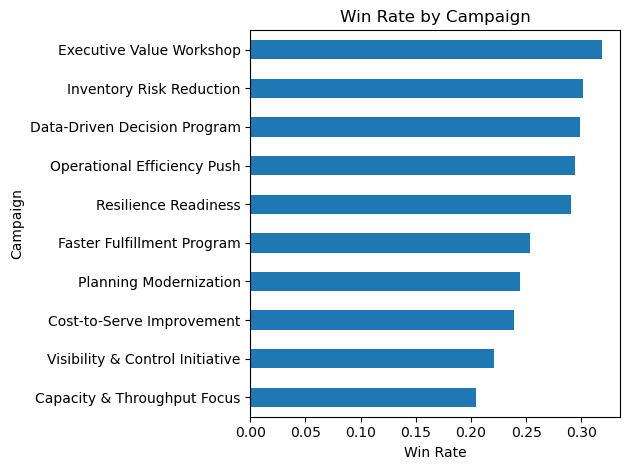

In [8]:
plt.figure()
win_rates.sort_values().plot(kind='barh')
plt.title('Win Rate by Campaign')
plt.xlabel('Win Rate')
plt.ylabel('Campaign')
plt.tight_layout()
plt.show()

In [9]:
won = closed[closed['final_outcome'] == 'Won'].copy()

deal_sizes = (won.groupby('campaign_name')['deal_size_usd'].agg(mean_deal_size='mean', median_deal_size='median', won_deals='count').sort_values('mean_deal_size', ascending=False)
)

deal_sizes

,mean_deal_size,median_deal_size,won_deals
campaign_name,,,
Planning Modernization,474941.176471,248000.0,51
Data-Driven Decision Program,407208.955224,282000.0,67
Operational Efficiency Push,406907.692308,303000.0,65
Executive Value Workshop,399044.776119,240000.0,67
Capacity & Throughput Focus,397511.111111,213000.0,45
Cost-to-Serve Improvement,373380.000000,263500.0,50
Inventory Risk Reduction,347971.428571,225000.0,70
Visibility & Control Initiative,333500.000000,202500.0,48
Faster Fulfillment Program,327016.393443,231000.0,61


<Figure size 640x480 with 0 Axes>

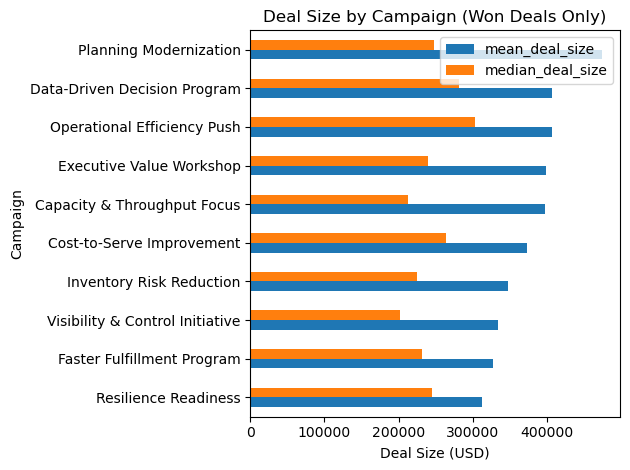

In [10]:
deal_sizes_plot = deal_sizes[['mean_deal_size','median_deal_size']].sort_values('mean_deal_size')


plt.figure()
deal_sizes_plot.plot(kind='barh')
plt.title('Deal Size by Campaign (Won Deals Only)')
plt.xlabel('Deal Size (USD)')
plt.ylabel('Campaign')
plt.tight_layout()
plt.show()

In [11]:
proposal = df[df['stage'] == 'Proposal'].copy()

proposal_speed = (proposal.groupby('campaign_name')['days_in_stage'].mean().sort_values().rename('avg_days_in_proposal'))

cycle_speed = (closed.groupby('campaign_name')['sales_cycle_days'].mean().sort_values().rename('avg_sales_cycle_days'))

acceleration_summary = pd.concat([proposal_speed, cycle_speed], axis=1).sort_values('avg_sales_cycle_days')
acceleration_summary

,avg_days_in_proposal,avg_sales_cycle_days
campaign_name,,
Executive Value Workshop,18.738095,73.709524
Operational Efficiency Push,20.343891,79.859729
Data-Driven Decision Program,20.455357,80.441964
Visibility & Control Initiative,20.493088,80.511521
Cost-to-Serve Improvement,20.526316,80.712919
Inventory Risk Reduction,20.590517,80.974138
Faster Fulfillment Program,20.597510,81.045643
Capacity & Throughput Focus,21.195455,83.227273
Resilience Readiness,21.866359,85.870968


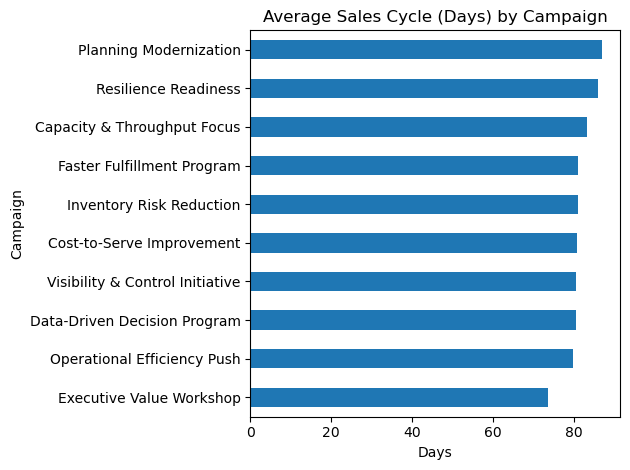

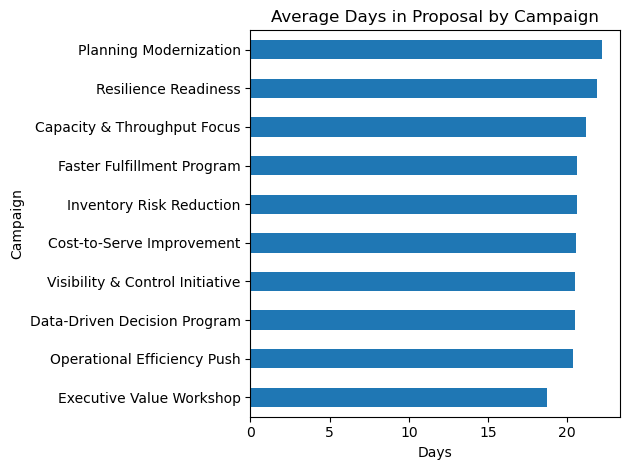

In [12]:
plt.figure()
acceleration_summary['avg_sales_cycle_days'].sort_values().plot(kind='barh')
plt.title('Average Sales Cycle (Days) by Campaign')
plt.xlabel('Days')
plt.ylabel('Campaign')
plt.tight_layout()
plt.show()
plt.figure()
acceleration_summary['avg_days_in_proposal'].sort_values().plot(kind='barh')
plt.title('Average Days in Proposal by Campaign')
plt.xlabel('Days')
plt.ylabel('Campaign')
plt.tight_layout()
plt.show()

In [13]:
motion_win_rate = (closed.groupby(['campaign_name','sales_motion'])['final_outcome'].apply(lambda s: (s == 'Won').mean()).unstack())

motion_win_rate

sales_motion,Digital,Field,Partner
campaign_name,,,
Capacity & Throughput Focus,0.106061,0.285714,0.178571
Cost-to-Serve Improvement,0.157895,0.260417,0.285714
Data-Driven Decision Program,0.203390,0.350427,0.291667
Executive Value Workshop,0.333333,0.308511,0.318182
Faster Fulfillment Program,0.276923,0.245455,0.242424
Inventory Risk Reduction,0.295775,0.301887,0.309091
Operational Efficiency Push,0.328125,0.320388,0.203704
Planning Modernization,0.132353,0.298969,0.295455
Resilience Readiness,0.213333,0.339806,0.307692


In [14]:
best_by_motion = motion_win_rate.idxmax()
best_by_motion

sales_motion
Digital        Executive Value Workshop
Field      Data-Driven Decision Program
Partner        Executive Value Workshop
dtype: object

<Figure size 640x480 with 0 Axes>

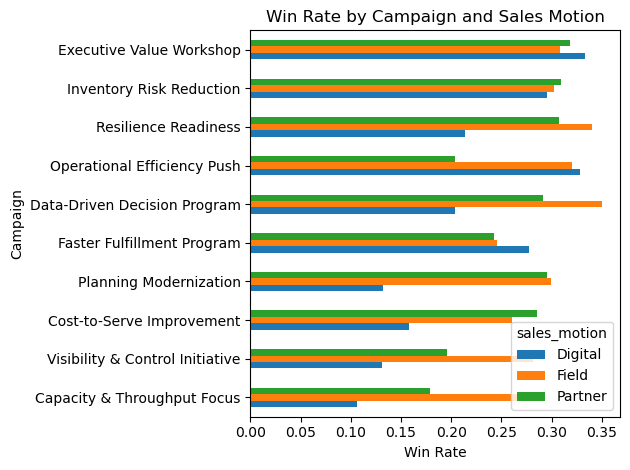

In [15]:
overall = motion_win_rate.mean(axis=1).sort_values()
motion_win_rate_sorted = motion_win_rate.loc[overall.index]
plt.figure()
motion_win_rate_sorted.plot(kind='barh')
plt.title('Win Rate by Campaign and Sales Motion')
plt.xlabel('Win Rate')
plt.ylabel('Campaign')
plt.tight_layout()
plt.show()

In [16]:
stall = (df[df['stage'].isin(['Discovery','Proposal'])].groupby(['campaign_name','stage'])['days_in_stage'].mean().unstack())

stall['proposal_minus_discovery'] = stall['Proposal'] - stall['Discovery']
stall.sort_values('proposal_minus_discovery', ascending=False)

stage,Discovery,Proposal,proposal_minus_discovery
campaign_name,,,
Planning Modernization,20.822967,22.210526,1.387560
Resilience Readiness,20.525346,21.866359,1.341014
Capacity & Throughput Focus,19.890909,21.195455,1.304545
Operational Efficiency Push,19.090498,20.343891,1.253394
Visibility & Control Initiative,19.299539,20.493088,1.193548
Data-Driven Decision Program,19.267857,20.455357,1.187500
Faster Fulfillment Program,19.410788,20.597510,1.186722
Cost-to-Serve Improvement,19.339713,20.526316,1.186603
Inventory Risk Reduction,19.431034,20.590517,1.159483


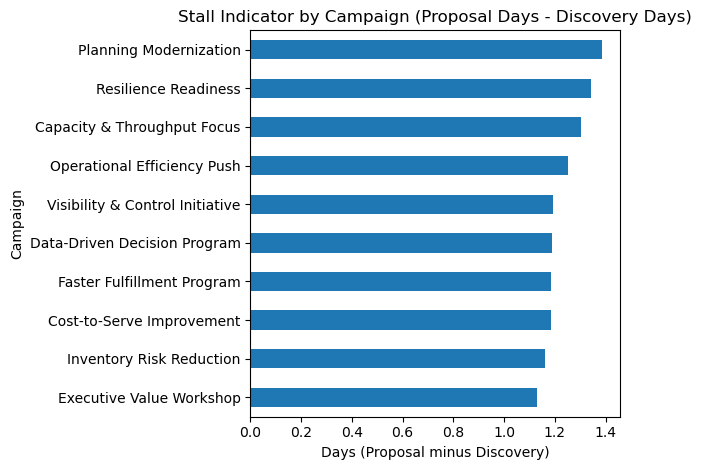

In [17]:
plt.figure()
stall['proposal_minus_discovery'].sort_values().plot(kind='barh')
plt.title('Stall Indicator by Campaign (Proposal Days - Discovery Days)')
plt.xlabel('Days (Proposal minus Discovery)')
plt.ylabel('Campaign')
plt.tight_layout()
plt.show()

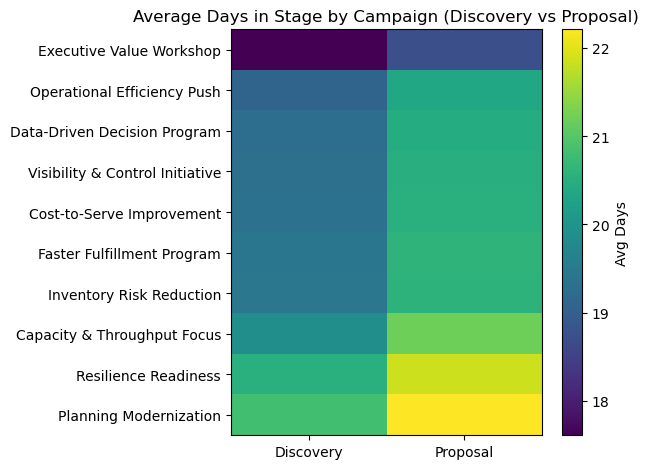

In [18]:
stall_matrix = stall[['Discovery','Proposal']].copy()
stall_matrix = stall_matrix.loc[stall_matrix.mean(axis=1).sort_values().index]
plt.figure()
plt.imshow(stall_matrix.values, aspect='auto')
plt.title('Average Days in Stage by Campaign (Discovery vs Proposal)')
plt.xticks([0, 1], ['Discovery', 'Proposal'])
plt.yticks(range(len(stall_matrix.index)), stall_matrix.index)
plt.colorbar(label='Avg Days')
plt.tight_layout()
plt.show()

In [20]:
scorecard = pd.DataFrame({

      'win_rate': win_rates,

      'avg_won_deal_size': deal_sizes['mean_deal_size'],

      'median_won_deal_size': deal_sizes['median_deal_size'],

      'avg_sales_cycle_days': cycle_speed,

      'avg_days_in_proposal': proposal_speed

  }).dropna()


  # Thresholds (quantiles adapt to this dataset)
win_rate_top = scorecard['win_rate'].quantile(0.75)

deal_size_top = scorecard['avg_won_deal_size'].quantile(0.75)

cycle_fast = scorecard['avg_sales_cycle_days'].quantile(0.25)
proposal_slow = scorecard['avg_days_in_proposal'].quantile(0.75)


def recommend(row):
    if row['win_rate'] >= win_rate_top and row['avg_won_deal_size'] >= deal_size_top:
        return 'SCALE (high win rate + high value)'

    if row['win_rate'] >= win_rate_top and row['avg_sales_cycle_days'] <= cycle_fast:
        return 'SCALE (high win rate + fast cycle)'

    if row['avg_days_in_proposal'] >= proposal_slow:
        return 'REFINE (stalls in Proposal)'

    if (row['win_rate'] < scorecard['win_rate'].median()) and (row['avg_sales_cycle_days'] > scorecard['avg_sales_cycle_days'].median()):
        return 'REDUCE/STOP (low win + slow cycle)'
        return 'MAINTAIN / TEST'
          
scorecard['recommendation'] = scorecard.apply(recommend, axis=1)
scorecard.sort_values(['recommendation','win_rate'], ascending=[True, False])

,win_rate,avg_won_deal_size,median_won_deal_size,avg_sales_cycle_days,avg_days_in_proposal,recommendation
campaign_name,,,,,,
Faster Fulfillment Program,0.253112,327016.393443,231000.0,81.045643,20.597510,REDUCE/STOP (low win + slow cycle)
Resilience Readiness,0.290323,313079.365079,245000.0,85.870968,21.866359,REFINE (stalls in Proposal)
Planning Modernization,0.244019,474941.176471,248000.0,87.057416,22.210526,REFINE (stalls in Proposal)
Capacity & Throughput Focus,0.204545,397511.111111,213000.0,83.227273,21.195455,REFINE (stalls in Proposal)
Executive Value Workshop,0.319048,399044.776119,240000.0,73.709524,18.738095,SCALE (high win rate + fast cycle)
Data-Driven Decision Program,0.299107,407208.955224,282000.0,80.441964,20.455357,SCALE (high win rate + high value)
Inventory Risk Reduction,0.301724,347971.428571,225000.0,80.974138,20.590517,None
Operational Efficiency Push,0.294118,406907.692308,303000.0,79.859729,20.343891,None
Cost-to-Serve Improvement,0.239234,373380.000000,263500.0,80.712919,20.526316,None
